<a href="https://colab.research.google.com/github/KanyantaM/final-year-project/blob/main/Final_Year_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA COLLECTION
In order to carry out the study a detailed load profile of the Electric Vehicle charging stations would introduce plus the already existing transformer loads. Because EV addoption is reletively new, actual charging data was not able to be collected. However, the driving and parking partterns of car owners can be studied and used to estimate/approximate the chharging behaviours of EV car owners.
For the already existing load, the load profiles of several hostels at the university of Zambia were closely studied a sample of the data collected in is shown below:

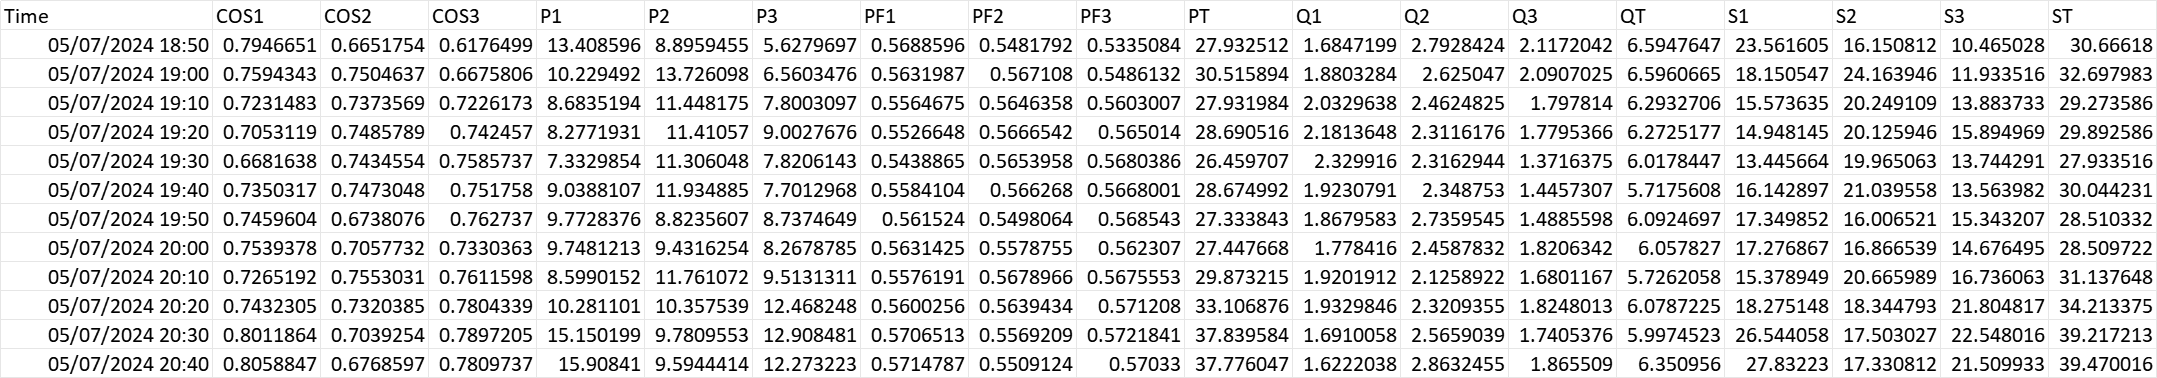

Similaryly total harmonic distortion data (THD) was collected as is shown in the image below:
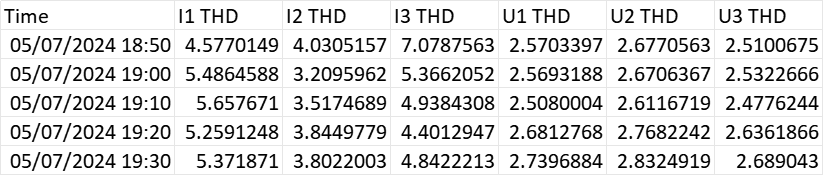

From here the data is then anlaysed to get the Load profile.

In [ ]:
#Getting the packages needed for the data processing
import pandas as pd
#package for data analysis
import matplotlib.pyplot as plt
#importing tools to perform maths
import numpy as np
#to perform ode's
from scipy.integrate import solve_ivp
#performing statistical analysis
from scipy import stats

In [ ]:
# Function to load CSV and prepare it for minute-by-minute analysis
def load_and_prepare_data(file_path, time_column='Time'):
    df = pd.read_csv(file_path, low_memory=False)

    # Convert the 'Time' column to datetime objects, with error handling
    df[time_column] = pd.to_datetime(df[time_column], format='%m/%d/%Y %H:%M', errors='coerce')

    # Drop rows where 'Time' could not be parsed
    df = df.dropna(subset=[time_column])

    # Extract the time part and convert to minutes since midnight (0 to 1440 minutes)
    df['Minutes'] = df[time_column].dt.hour * 60 + df[time_column].dt.minute

    # Set the 'Minutes' as the index
    df = df.set_index('Minutes')

    # Group by the minute intervals and calculate the mean for each minute
    minute_data = df.groupby('Minutes').mean()

    # Reindex to ensure every minute from 0 to 1440 is included
    full_index = pd.RangeIndex(start=0, stop=1441, step=1)  # 0 to 1440 minutes
    minute_data = minute_data.reindex(full_index)

    # Fill missing values using interpolation to smooth the lines (optional)
    minute_data = minute_data.interpolate(method='linear')  # You can also use .ffill(), .bfill() as alternatives

    return minute_data

In [ ]:
# Function to load CSV and prepare it for hourly analysis and perform a moving average
def moving_average(file_path, time_column='Time'):
    df = pd.read_csv(file_path, low_memory=False)

    # Convert the 'Time' column to datetime objects, with error handling
    df[time_column] = pd.to_datetime(df[time_column], format='%m/%d/%Y %H:%M', errors='coerce')

    # Drop rows where 'Time' could not be parsed
    df = df.dropna(subset=[time_column])

    # Extract hour from the 'Time' column
    df['Hour'] = df[time_column].dt.hour

    # Set the 'Hour' as the index
    df = df.set_index('Hour')

    # Group by hour and calculate the mean for each hour
    hourly_data = df.groupby('Hour').mean()

    return hourly_data

# Z-Score Normalization function
def z_score_normalize(df):
    return (df - df.mean()) / df.std()

# Reverse Z-Score Normalization function (denormalization)
def reverse_z_score_normalize(df_normalized, original_df):
    return (df_normalized * original_df.std()) + original_df.mean()

## Hostel Load Profile

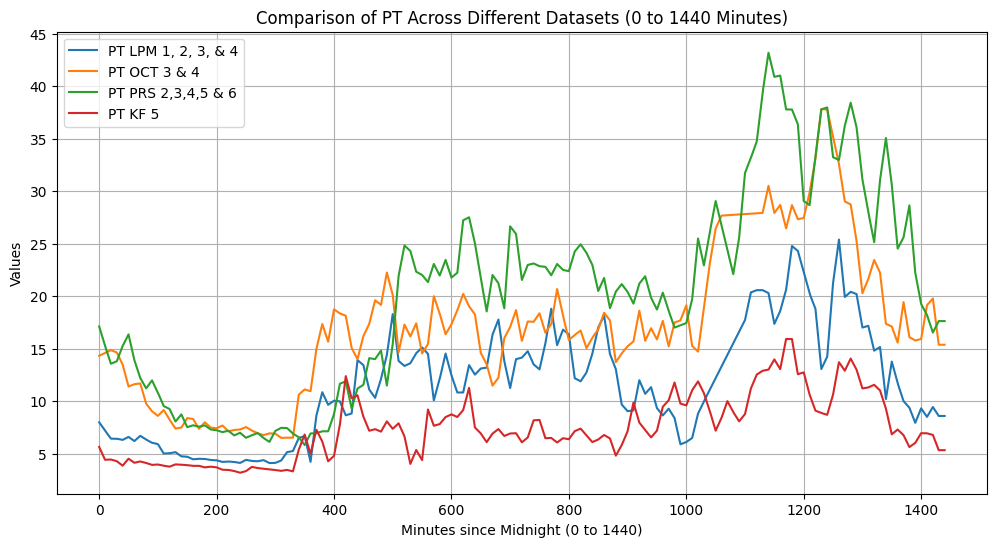

In [ ]:
# Load and prepare the datasets
df1 = load_and_prepare_data("/content/drive/MyDrive/EV Final project/Mwansa's data/Mwanawasa Power & power factor.csv")
df2 = load_and_prepare_data("/content/drive/MyDrive/EV Final project/Mwansa's data/October-3&4  Power & power factor.csv")
df3 = load_and_prepare_data("/content/drive/MyDrive/EV Final project/Mwansa's data/President 2-6 Power & power factor (1).csv")
df4 = load_and_prepare_data("/content/drive/MyDrive/EV Final project/Mwansa's data/Kaufe Block 5 Power Pf & Cos (2).csv")

# Merge the datasets based on the 'Minutes' index
merged_df_raw = pd.concat([df1, df2, df3, df4], axis=1, keys=['File1', 'File2', 'File3', 'File4'])

# Plot the comparison for a selected variable, e.g., 'PT'
plt.figure(figsize=(12, 6))

plt.plot(merged_df_raw['File1', 'PT'], label='PT LPM 1, 2, 3, & 4')
plt.plot(merged_df_raw['File2', 'PT'], label='PT OCT 3 & 4')
plt.plot(merged_df_raw['File3', 'PT'], label='PT PRS 2,3,4,5 & 6')
plt.plot(merged_df_raw['File4', 'PT'], label='PT KF 5')

plt.title('Comparison of PT Across Different Datasets (0 to 1440 Minutes)')
plt.xlabel('Minutes since Midnight (0 to 1440)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

      minutes        PT         ST
1436     1436  9.245184  11.821585
1437     1437  9.245184  11.821585
1438     1438  9.245184  11.821585
1439     1439  9.245184  11.821585
1440     1440  9.245184  11.821585


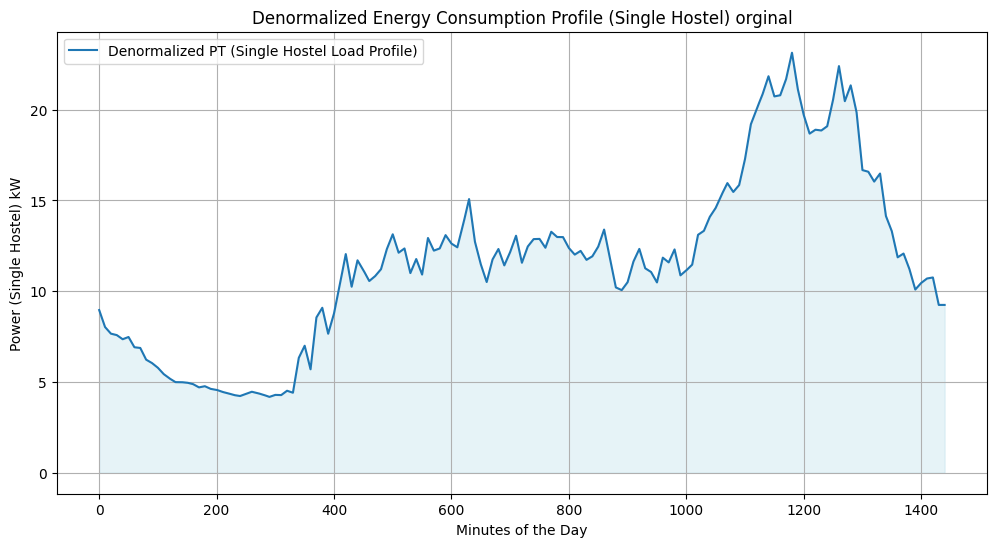

In [ ]:
# Normalize the data for each file based on the number of hostels (apply only to numeric columns)
df1_normalized = z_score_normalize(df1.select_dtypes(include=['float64', 'int64']).apply(lambda x: x / 4))  # File1 has 4 hostels
df2_normalized = z_score_normalize(df2.select_dtypes(include=['float64', 'int64']).apply(lambda x: x / 2))  # File2 has 2 hostels
df3_normalized = z_score_normalize(df3.select_dtypes(include=['float64', 'int64']).apply(lambda x: x / 4))  # File3 has 4 hostels
df4_normalized = z_score_normalize(df4.select_dtypes(include=['float64', 'int64']).apply(lambda x: x / 1))  # File4 has 1 hostel

# Merge the normalized datasets based on the 'Hour' index
merged_df_normalized = pd.concat([df1_normalized, df2_normalized, df3_normalized, df4_normalized], axis=1, keys=['File1', 'File2', 'File3', 'File4'])

# Calculate the average PT across all normalized hostels
merged_df_normalized['Average_PT'] = (merged_df_normalized['File1', 'PT'] +
                                      merged_df_normalized['File2', 'PT'] +
                                      merged_df_normalized['File3', 'PT'] +
                                      merged_df_normalized['File4', 'PT']) / 4  # Taking the average of PT

merged_df_normalized['Average_ST'] = (merged_df_normalized['File1', 'ST'] +
                                      merged_df_normalized['File2', 'ST'] +
                                      merged_df_normalized['File3', 'ST'] +
                                      merged_df_normalized['File4', 'ST']) / 4  # Taking the average of ST

# De-normalize the average to get back to the original scale
# Use df1['PT'] as the reference scale for denormalization
single_hostel_profile_PT = reverse_z_score_normalize(merged_df_normalized['Average_PT'], df1['PT'])
single_hostel_profile_ST = reverse_z_score_normalize(merged_df_normalized['Average_ST'], df1['ST'])

# Create a DataFrame for the hourly data
load_profile_h_df_minutes = pd.DataFrame({
    'minutes': range(1441),
    'PT': single_hostel_profile_PT,
    'ST': single_hostel_profile_ST
})

print(load_profile_h_df_minutes.tail())

# Create a DataFrame for the 1440 minutes
minutes = range(1440)

# Plot the final result
plt.figure(figsize=(12, 6))

plt.plot(load_profile_h_df_minutes['minutes'], load_profile_h_df_minutes['PT'], label='Denormalized PT (Single Hostel Load Profile)')
plt.fill_between(load_profile_h_df_minutes['minutes'], load_profile_h_df_minutes['PT'], alpha=0.3, color='lightblue')

plt.title('Denormalized Energy Consumption Profile (Single Hostel) orginal')
plt.xlabel('Minutes of the Day')
plt.ylabel('Power (Single Hostel) kW')
plt.legend()
plt.grid(True)
plt.show()


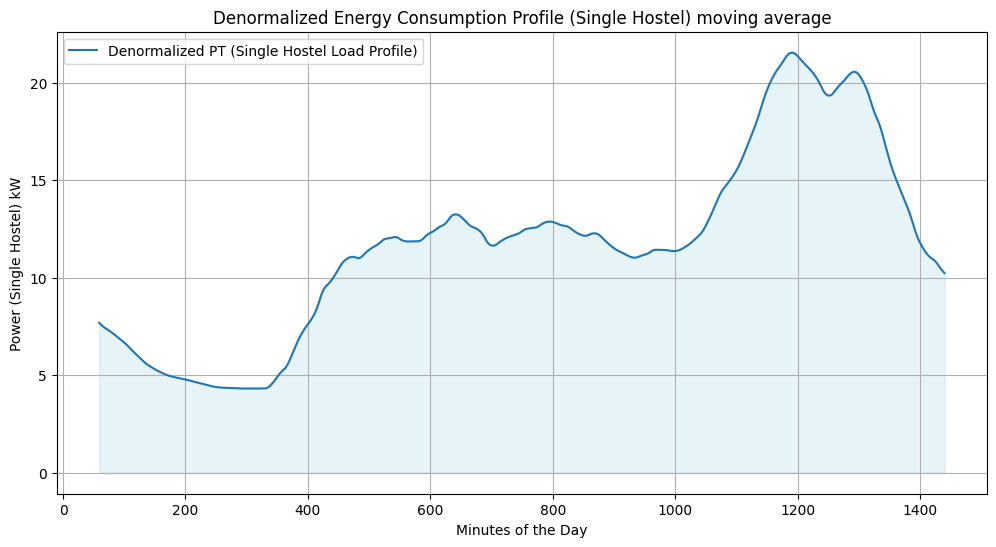

In [ ]:
load_profile_h_df_moving_average = load_profile_h_df_minutes.copy()
load_profile_h_df_moving_average ['PT']= load_profile_h_df_minutes['PT'].rolling(window=60).mean()
load_profile_h_df_moving_average ['ST'] = load_profile_h_df_minutes['ST'].rolling(window=60).mean()

#ploting the final result
plt.figure(figsize=(12, 6))

plt.plot(load_profile_h_df_moving_average['minutes'], load_profile_h_df_moving_average['PT'], label='Denormalized PT (Single Hostel Load Profile)')
plt.fill_between(load_profile_h_df_moving_average['minutes'], load_profile_h_df_moving_average['PT'], alpha=0.3, color='lightblue')

plt.title('Denormalized Energy Consumption Profile (Single Hostel) moving average')
plt.xlabel('Minutes of the Day')
plt.ylabel('Power (Single Hostel) kW')
plt.legend()
plt.grid(True)
plt.show()


## EV load profile Simulation

Because of the low adoption of EV's in the country actual data on the charging partterns of EV car owners couldn't be obtained. Instead, what was done was time was spent to monitor the parking partterns of car owners on the University of Zambia Old Residents carpark. From here it was noted that most cars arrive in the mornings and a few of them leave around noon. return post nooon and all leave by the evenings. After consistent monitoring of the vehicle activity a small dataset was collected from which the mean time of vehichle arrival and leaving/ time away was then made using statistical methods. to find the mean times and standard deviations of these patterns.

And the following was found that the arrival time of the cars had a mean of 8.45 hours (08 27 hrs) with a standard deviation of 1 hour.

For the departure of some cars, it was estimated that about 40% of the cars leave the car park at slightly after noon with the statistacal data we had collected showing that the mean of the time the cars are leaving was at 14.5 hours or 14 30 hrs, with a standard deviataion of 0.56 hours or 33.54 minutes.

From these times the time an electric vehicle is connected to charge can be estimated. And to increase the realistic nature of the approximation a monte carlo simulation was run with a 10000 test points within the normal distribution of the estimated times the drivers arrive at the carparks in the mornings and afternoons

To find out charging times, it is known from surveys taken in the country that the most widley adopted EV charger in low voltage residential distribution networks is the level 2 charger that has a power output of 7kW.
Also the power rating of the car chosen was the nissan leaf as it is currently the most adopted electric vehicle

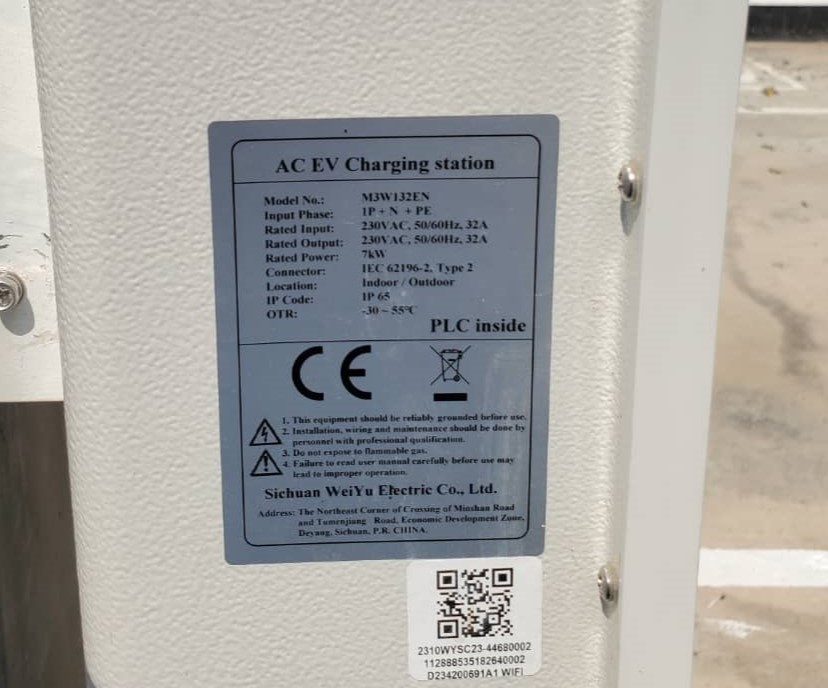

And the consumption of the EV been found to be about 0.2kW/km

Average THD Profile for EV Charging:
      minutes   PT   ST
1435     1435  0.0  0.0
1436     1436  0.0  0.0
1437     1437  0.0  0.0
1438     1438  0.0  0.0
1439     1439  0.0  0.0


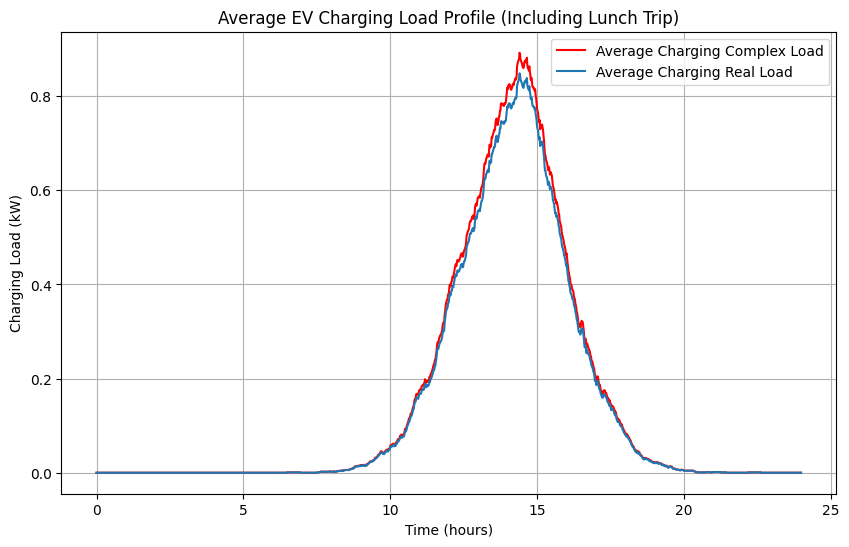

In [ ]:
# Constants
charging_power = 7.0  # kW (Level 2 charger, 230V, 32A)
charging_complex_power = 7.36 #kVA level 2 charger
distance_morning_evening = 16  # km (total distance to and from work, morning and evening)
distance_lunch = 4  # km (distance to and from lunch)
energy_per_km = 0.2  # kWh per km
time_step = 1  # Time step of 1 minute
simulation_duration = 1440  # 1440 minutes = 1 day
n_iterations = 10000  # Monte Carlo iterations
average_speed = 36  # km/h

# Stochastic variables
mean_parking_time = 810
std_parking_time = 110
mean_driving_time = 27
std_driving_time = 5

# Lunch commute variables
lunch_start_time_mean, lunch_start_time_std = 780, 30  # 13:00 (780 minutes)
lunch_away_time_mean, lunch_time_away_std = 90, 15  # Most people have lunch for ~1:30 hours
energy_driving_mean, energy_driving_std = 48, 12  # Energy consumed to and from lunch

# Monte Carlo simulation for n_iterations iterations
load_profiles_real = np.zeros((n_iterations, simulation_duration))  # To store load profiles
load_profiles_complex = np.zeros((n_iterations, simulation_duration)) #To store the complex of the charger

for i in range(n_iterations):
    # Morning and Evening commute:
    # Generate random parking time (Li) and driving time (Di) from normal distributions
    Li = np.random.normal(mean_parking_time, std_parking_time)
    Di = np.random.normal(mean_driving_time, std_driving_time)

    # Ensure times are within realistic bounds
    Li = max(0, min(Li, simulation_duration))
    Di = max(0, min(Di, simulation_duration))

    # Calculate total energy consumed for morning and evening commute
    energy_consumed_morning_evening = distance_morning_evening * energy_per_km  # kWh

    # Time available for charging after morning-evening commute
    charging_start_time = Li + Di  # Time when charging begins
    charging_duration_morning_evening = energy_consumed_morning_evening / charging_power * 60  # Charging duration in minutes

    # Ensure charging doesn't exceed the simulation time
    charging_end_time = min(charging_start_time + charging_duration_morning_evening, simulation_duration)

    # Distribute charging load over time for morning and evening commute
    for t in range(int(charging_start_time), int(charging_end_time)):
        if t < simulation_duration:  # Ensure we stay within the simulation time
            load_profiles_real[i, t] = charging_power
            load_profiles_complex[i, t] = charging_complex_power


    # Lunch commute:
    # Generate random lunch starting time (Lst), lunch away time (Lat), and energy consumption during lunch commutes from normal distributions
    Lst = np.random.normal(lunch_start_time_mean, lunch_start_time_std)
    Lat = np.random.normal(lunch_away_time_mean, lunch_time_away_std)

    # Ensure lunch times are within realistic bounds
    Lst = max(0, min(Lst, simulation_duration))

    # Calculate total energy consumed during lunch commute
    energy_consumed_lunch = np.random.normal(energy_driving_mean, energy_driving_std)
    energy_consumed_lunch = max(0, min(energy_consumed_lunch, distance_lunch * energy_per_km))  # Ensuring energy is within realistic bounds

    # Find the time one starts charging after lunch
    charging_start_time_lunch = Lst + Lat
    charging_duration_lunch = energy_consumed_lunch / charging_power * 60  # Charging duration in minutes

    # Ensure lunch charging doesn't exceed the simulation time
    charging_end_time_lunch = min(charging_start_time_lunch + charging_duration_lunch, simulation_duration)

    # Distribute charging load over time for lunch trip
    for t in range(int(charging_start_time_lunch), int(charging_end_time_lunch)):
        if t < simulation_duration:  # Ensure we stay within the simulation time
            load_profiles_real[i, t] = charging_power * 0.35  #Percentage that actually go for lunch
            load_profiles_complex[i, t] = charging_complex_power * 0.35

# Calculate the average load profile over all iterations
average_load_profile_ev_average_PT = np.mean(load_profiles_real, axis=0)
average_load_profile_ev_average_ST = np.mean(load_profiles_complex, axis=0)

# Convert time axis from minutes to hours
time_in_hours_thd = np.arange(simulation_duration)
average_load_profile_ev_df = pd.DataFrame({
    'minutes': range(len(average_load_profile_ev_average_PT)),
    'PT': average_load_profile_ev_average_PT,
    'ST': average_load_profile_ev_average_ST
})
print("Average THD Profile for EV Charging:")
print(average_load_profile_ev_df.tail())

# Convert time axis from minutes to hours
time_in_hours = np.arange(simulation_duration) / 60  # Convert minutes to hours

# Plot the average load profile
plt.figure(figsize=(10, 6))
plt.plot(time_in_hours, average_load_profile_ev_average_ST, color='red', label='Average Charging Complex Load')
plt.plot(time_in_hours, average_load_profile_ev_average_PT, label='Average Charging Real Load')

plt.title('Average EV Charging Load Profile (Including Lunch Trip)')
plt.xlabel('Time (hours)')  # Update x-axis label to hours
plt.ylabel('Charging Load (kW)')
plt.legend()
plt.grid(True)
plt.show()


## Combining of the two load profiles

Some inportant constants and imports

In [ ]:
# number of EVs and hostels
N = 15  # Number of EVs
H = 24   # Number of hostels

Average THD Profile for Hostel Charging:
      minutes          PT          ST
1436     1436  248.901241  307.513156
1437     1437  248.008334  306.627708
1438     1438  247.149631  305.777614
1439     1439  246.325132  304.962875
1440     1440  245.534838  304.183492
Average THD Profile for EVC Charging:
      minutes   PT   ST
1435     1435  0.0  0.0
1436     1436  0.0  0.0
1437     1437  0.0  0.0
1438     1438  0.0  0.0
1439     1439  0.0  0.0


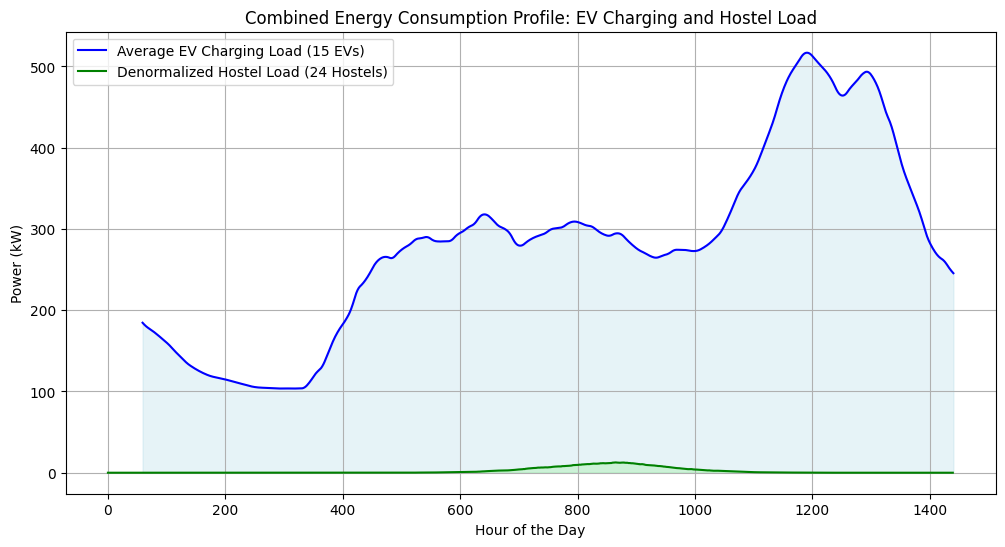

In [ ]:
# Scale hostel profile by number of hostels
average_load_profile_all_h_df = load_profile_h_df_moving_average.copy()
average_load_profile_all_h_df['PT'] = load_profile_h_df_moving_average['PT'] * H
average_load_profile_all_h_df['ST'] = load_profile_h_df_moving_average['ST'] * H

print("Average THD Profile for Hostel Charging:")
print(average_load_profile_all_h_df.tail())

# Scale ev profile by number of ev's
average_load_profile_all_ev_df = average_load_profile_ev_df.copy()
average_load_profile_all_ev_df['PT'] = average_load_profile_ev_df['PT'] * N
average_load_profile_all_ev_df['ST'] = average_load_profile_ev_df['ST'] * N

print("Average THD Profile for EVC Charging:")
print(average_load_profile_all_ev_df.tail())

# --- Plot both profiles together ---
plt.figure(figsize=(12, 6))

plt.plot(range((len(average_load_profile_all_h_df))), average_load_profile_all_h_df['PT'], label=f'Average EV Charging Load ({N} EVs)', color='blue')
plt.fill_between(range(len(average_load_profile_all_h_df)), average_load_profile_all_h_df['PT'], alpha=0.3, color='lightblue')

# Plot the hostel load profile
plt.plot(range((len(average_load_profile_all_ev_df))), average_load_profile_all_ev_df['PT'], label=f'Denormalized Hostel Load ({H} Hostels)', color='green')
plt.fill_between(range((len(average_load_profile_all_ev_df))), average_load_profile_all_ev_df['PT'], alpha=0.3, color='lightgreen')

# Add titles and labels
plt.title('Combined Energy Consumption Profile: EV Charging and Hostel Load')
plt.xlabel('Minutes of the Day')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.show()


## Hostel THD Profile

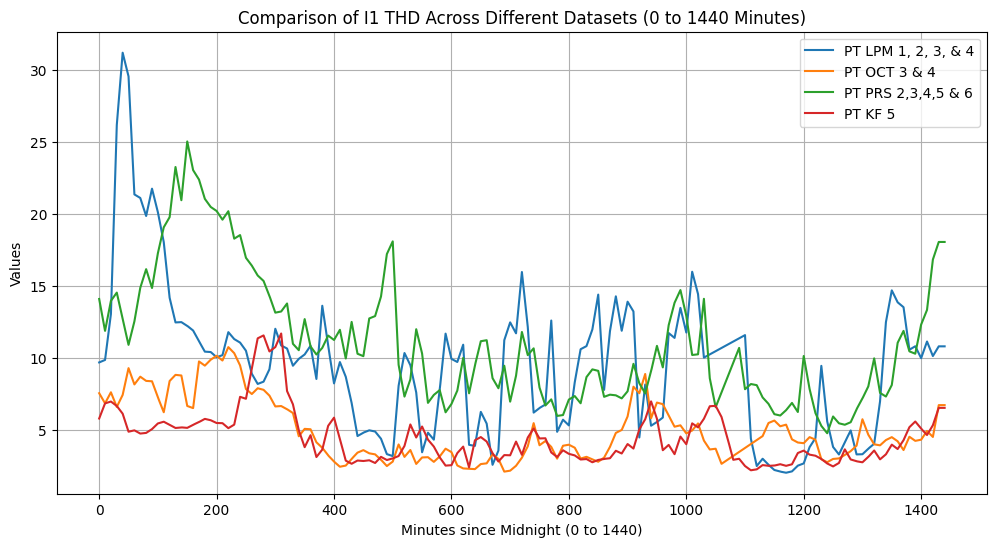

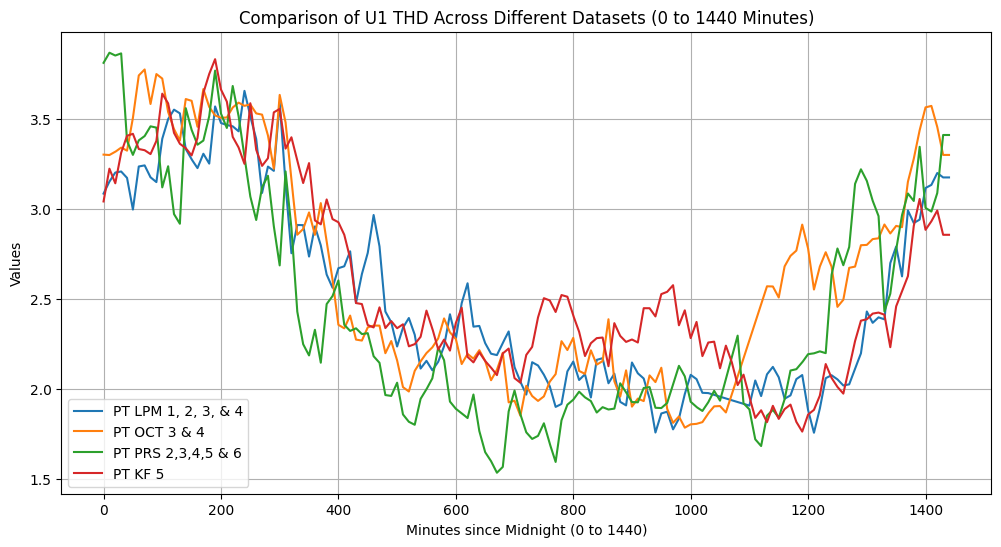

In [ ]:
# Load and prepare the datasets
thd_df1 = load_and_prepare_data("/content/drive/MyDrive/EV Final project/Mwansa's data/Mwanawasa THD (1).csv")
thd_df2 = load_and_prepare_data("/content/drive/MyDrive/EV Final project/Mwansa's data/October-3&4  THD (1).csv")
thd_df3 = load_and_prepare_data("/content/drive/MyDrive/EV Final project/Mwansa's data/president 2- 6 THD.csv")
thd_df4 = load_and_prepare_data("/content/drive/MyDrive/EV Final project/Mwansa's data/Kaufe Block 5 THD (4).csv")

# Merge the datasets based on the 'Minutes' index
merged_df = pd.concat([thd_df1, thd_df2, thd_df3, thd_df4], axis=1, keys=['File1', 'File2', 'File3', 'File4'])

# Plot the comparison for a selected variable
plt.figure(figsize=(12, 6))

#plotting file I1 THD against minutes in a solid lines
plt.plot(merged_df['File1', 'I1 THD'], label='PT LPM 1, 2, 3, & 4')
plt.plot(merged_df['File2', 'I1 THD'], label='PT OCT 3 & 4')
plt.plot(merged_df['File3', 'I1 THD'], label='PT PRS 2,3,4,5 & 6')
plt.plot(merged_df['File4', 'I1 THD'], label='PT KF 5')


plt.title('Comparison of I1 THD Across Different Datasets (0 to 1440 Minutes)')
plt.xlabel('Minutes since Midnight (0 to 1440)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

#plotting file U1 THD against minutes in a solid lines
# Plot the comparison for a selected variable
plt.figure(figsize=(12, 6))

#plotting file I1 THD against minutes in a solid lines
plt.plot(merged_df['File1', 'U1 THD'], label='PT LPM 1, 2, 3, & 4')
plt.plot(merged_df['File2', 'U1 THD'], label='PT OCT 3 & 4')
plt.plot(merged_df['File3', 'U1 THD'], label='PT PRS 2,3,4,5 & 6')
plt.plot(merged_df['File4', 'U1 THD'], label='PT KF 5')


plt.title('Comparison of U1 THD Across Different Datasets (0 to 1440 Minutes)')
plt.xlabel('Minutes since Midnight (0 to 1440)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

A clear parttern is seen in U1 THD. Hence U1 THD is used

Average THD Profile for Hostel Charging:
      minutes       THD
1436     1436  3.266659
1437     1437  3.269575
1438     1438  3.272355
1439     1439  3.274997
1440     1440  3.277503


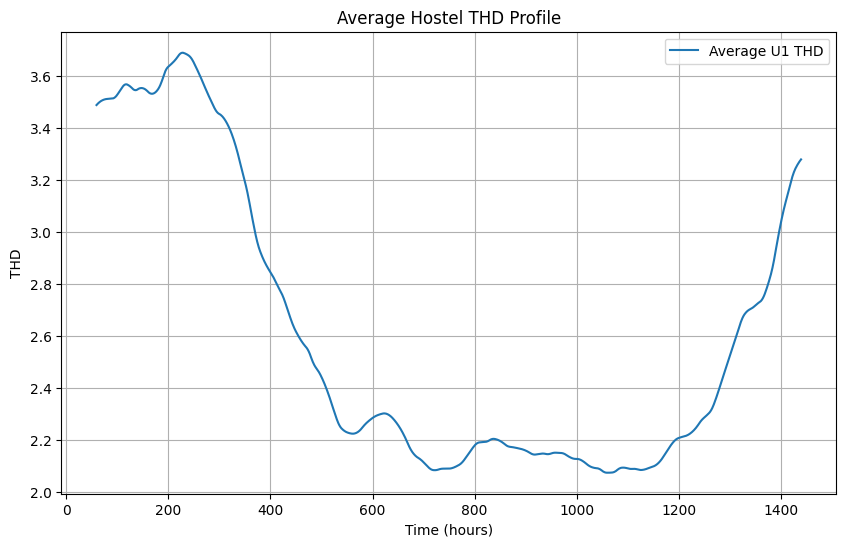

In [ ]:
# Normalize the data for each file based on the number of hostels (apply only to numeric columns)
thd_df1_normalized = z_score_normalize(thd_df1.select_dtypes(include=['float64', 'int64']).apply(lambda x: x / 4))  # File1 has 4 hostels
thd_df2_normalized = z_score_normalize(thd_df2.select_dtypes(include=['float64', 'int64']).apply(lambda x: x / 2))  # File2 has 2 hostels
thd_df3_normalized = z_score_normalize(thd_df3.select_dtypes(include=['float64', 'int64']).apply(lambda x: x / 4))  # File3 has 4 hostels
thd_df4_normalized = z_score_normalize(thd_df4.select_dtypes(include=['float64', 'int64']).apply(lambda x: x / 1))  # File4 has 1 hostel

# Merge the normalized datasets based on the 'Hour' index
merged_thd_df_normalized = pd.concat([thd_df1_normalized, thd_df2_normalized, thd_df3_normalized, thd_df4_normalized], axis=1, keys=['File1', 'File2', 'File3', 'File4'])

# Calculate the average PT across all normalized hostels
merged_thd_df_normalized['Average_U1_THD'] = (merged_thd_df_normalized['File1', 'U1 THD'] +
                                      merged_thd_df_normalized['File2', 'U1 THD'] +
                                      merged_thd_df_normalized['File3', 'U1 THD'] +
                                      merged_thd_df_normalized['File4', 'U1 THD']) / 4  # Taking the average of U1 THHD

# De-normalize the average to get back to the original scale
average_single_hostel_thd = reverse_z_score_normalize(merged_thd_df_normalized['Average_U1_THD'], thd_df2['U1 THD'])

average_single_hostel_thd_moving_average = average_single_hostel_thd.rolling(window=60).mean()

average_single_hostel_thd_df = pd.DataFrame({
    'minutes': range(len(average_single_hostel_thd)),
    'THD': average_single_hostel_thd_moving_average
})

print("Average THD Profile for Hostel Charging:")
print(average_single_hostel_thd_df.tail())

# Plot the average load profile
plt.figure(figsize=(10, 6))
plt.plot(average_single_hostel_thd_df['THD'], label='Average U1 THD')
# plt.fill_between(time_in_hours,average_single_hostel_thd, alpha=0.3, color='lightblue')
plt.title('Average Hostel THD Profile')
plt.xlabel('Time (hours)')  # Update x-axis label to hours
plt.ylabel('THD')
plt.legend()
plt.grid(True)
plt.show()

## EV THD Profile

["The worst case hypothetical EV charger model was constructed by using maximum permissible values from the International Electrotechnical Commission (IEC) 1000–3-4 recommended limits for harmonic currents for equipment. This simulated charger current waveform in Fig. 1 has a current THD of 17.3%. These limits have been adopted in the form of an IWC Record of Consensus (ROC) recommendation for EV charger current distortion. The worst case scenario also assumed that all EV owners used the same EV charger, removing the effects of harmonic phase cancellation."](https://ieeexplore.ieee.org/abstract/document/916965)

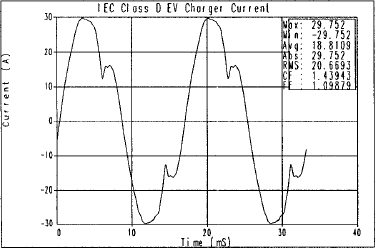

["For the marginal case scenario, an actual commercial charger with the highest current THD (Honda EV charger with 14.3% THD) was used, as compared to the worst case simulation scenario charger with 17.3% current THD. The other parameters (system data and the appliances) remained the same, as in the worst case simulation scenario. The charger's current waveform appears in Fig. 4 and the results in Table D."](https://ieeexplore.ieee.org/abstract/document/916965)
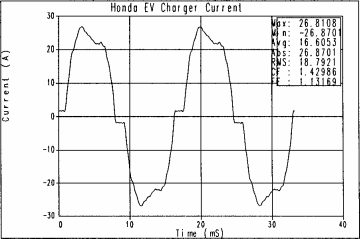




Average THD Profile for EV Charging:
      minutes  THD
1436     1436  0.0
1437     1437  0.0
1438     1438  0.0
1439     1439  0.0
1440     1440  0.0


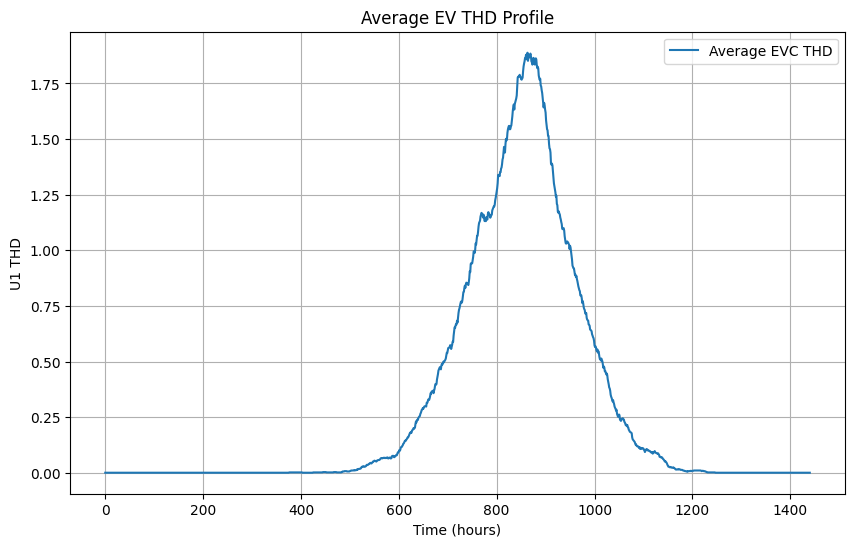

In [ ]:
# Constants
charging_THD = 14.3
simulation_duration = 1441

# Monte Carlo simulation for n_iterations iterations
thd_profiles = np.zeros((n_iterations, simulation_duration))  # To store load profiles

for i in range(n_iterations):
    # Morning and Evening commute:
    # Generate random parking time (Li) and driving time (Di) from normal distributions
    Li = np.random.normal(mean_parking_time, std_parking_time)
    Di = np.random.normal(mean_driving_time, std_driving_time)

    # Ensure times are within realistic bounds
    Li = max(0, min(Li, simulation_duration))
    Di = max(0, min(Di, simulation_duration))

    # Calculate total energy consumed for morning and evening commute
    energy_consumed_morning_evening = distance_morning_evening * energy_per_km  # kWh

    # Time available for charging after morning-evening commute
    charging_start_time = Li + Di  # Time when charging begins
    charging_duration_morning_evening = energy_consumed_morning_evening / charging_power * 60  # Charging duration in minutes

    # Ensure charging doesn't exceed the simulation time
    charging_end_time = min(charging_start_time + charging_duration_morning_evening, simulation_duration)

    # Distribute charging thd over time for morning and evening commute
    for t in range(int(charging_start_time), int(charging_end_time)):
        if t < simulation_duration:  # Ensure we stay within the simulation time
            thd_profiles[i, t] = charging_THD

    # Lunch commute:
    # Generate random lunch starting time (Lst), lunch away time (Lat), and energy consumption during lunch commutes from normal distributions
    Lst = np.random.normal(lunch_start_time_mean, lunch_start_time_std)
    Lat = np.random.normal(lunch_away_time_mean, lunch_time_away_std)

    # Ensure lunch times are within realistic bounds
    Lst = max(0, min(Lst, simulation_duration))

    # Calculate total energy consumed during lunch commute
    energy_consumed_lunch = np.random.normal(energy_driving_mean, energy_driving_std)
    energy_consumed_lunch = max(0, min(energy_consumed_lunch, distance_lunch * energy_per_km))  # Ensuring energy is within realistic bounds

    # Find the time one starts charging after lunch
    charging_start_time_lunch = Lst + Lat
    charging_duration_lunch = energy_consumed_lunch / charging_power * 60  # Charging duration in minutes

    # Ensure lunch charging doesn't exceed the simulation time
    charging_end_time_lunch = min(charging_start_time_lunch + charging_duration_lunch, simulation_duration)

    # Distribute charging load over time for lunch trip
    for t in range(int(charging_start_time_lunch), int(charging_end_time_lunch)):
        if t < simulation_duration:  # Ensure we stay within the simulation time
            thd_profiles[i, t] = charging_power

# Calculate the average load profile over all iterations
average_thd_profile_ev = np.mean(thd_profiles, axis=0)

# Convert time axis from minutes to hours
time_in_hours_thd = np.arange(simulation_duration)
average_thd_profile_ev = pd.DataFrame({
    'minutes': range(len(average_thd_profile_ev)),
    'THD': average_thd_profile_ev
})
print("Average THD Profile for EV Charging:")
print(average_thd_profile_ev.tail())

# Plot the average load profile
plt.figure(figsize=(10, 6))
plt.plot(range(len(average_thd_profile_ev)),average_thd_profile_ev['THD'], label='Average EVC THD')
plt.title('Average EV THD Profile')
plt.xlabel('Time (hours)')  # Update x-axis label to hours
plt.ylabel('U1 THD')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("Average THD Profile for EV Charging:")
print(average_thd_profile_ev.tail())

print("Average THD Profile for Hostel Load:")
print(average_single_hostel_thd_df.tail())

#checking for null values
print(average_thd_profile_ev.isnull().sum())
print(average_single_hostel_thd_df.isnull().sum())

Average THD Profile for EV Charging:
      minutes  THD
1436     1436  0.0
1437     1437  0.0
1438     1438  0.0
1439     1439  0.0
1440     1440  0.0
Average THD Profile for Hostel Load:
      minutes       THD
1436     1436  3.266659
1437     1437  3.269575
1438     1438  3.272355
1439     1439  3.274997
1440     1440  3.277503
minutes    0
THD        0
dtype: int64
minutes     0
THD        59
dtype: int64


In [ ]:
average_single_hostel_thd_df['THD'] = average_single_hostel_thd_df['THD'].ffill().bfill()

[3.48649857 3.48649857 3.48649857 ... 3.27235456 3.27499709 3.27750274]
[0. 0. 0. ... 0. 0. 0.]
(1441,)
(1441,)
2.6341506160420005 0.5729359176915904


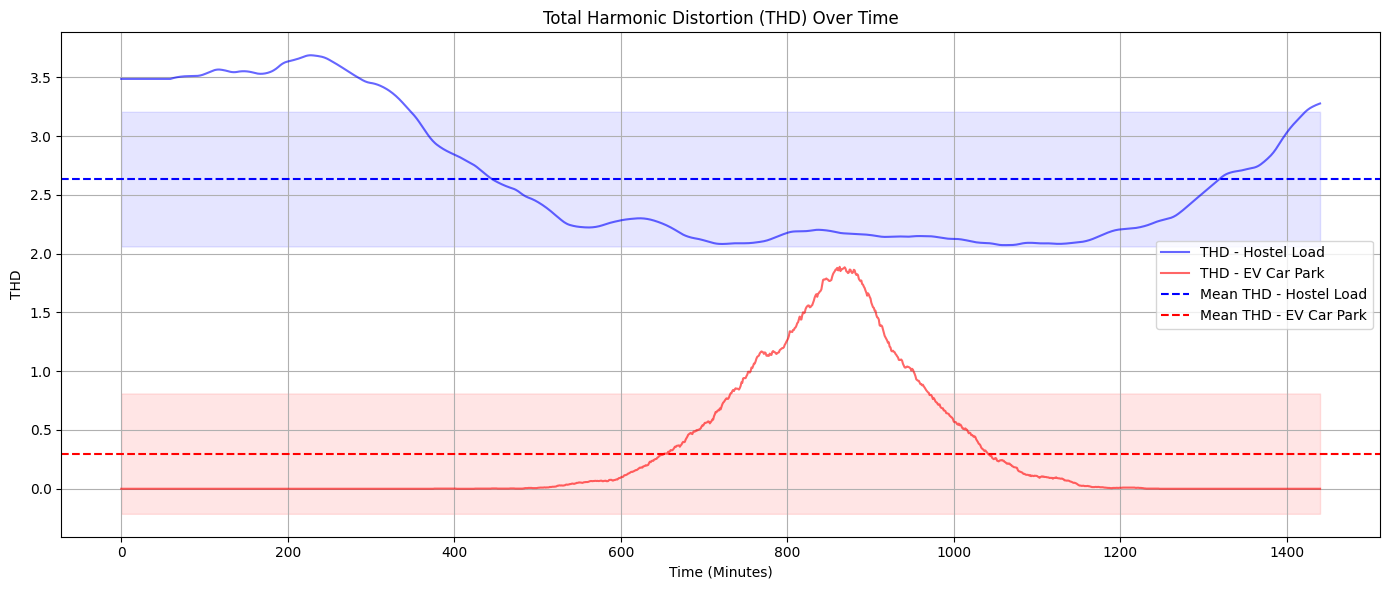

T-statistic: 115.3529187252853, P-value: 0.0


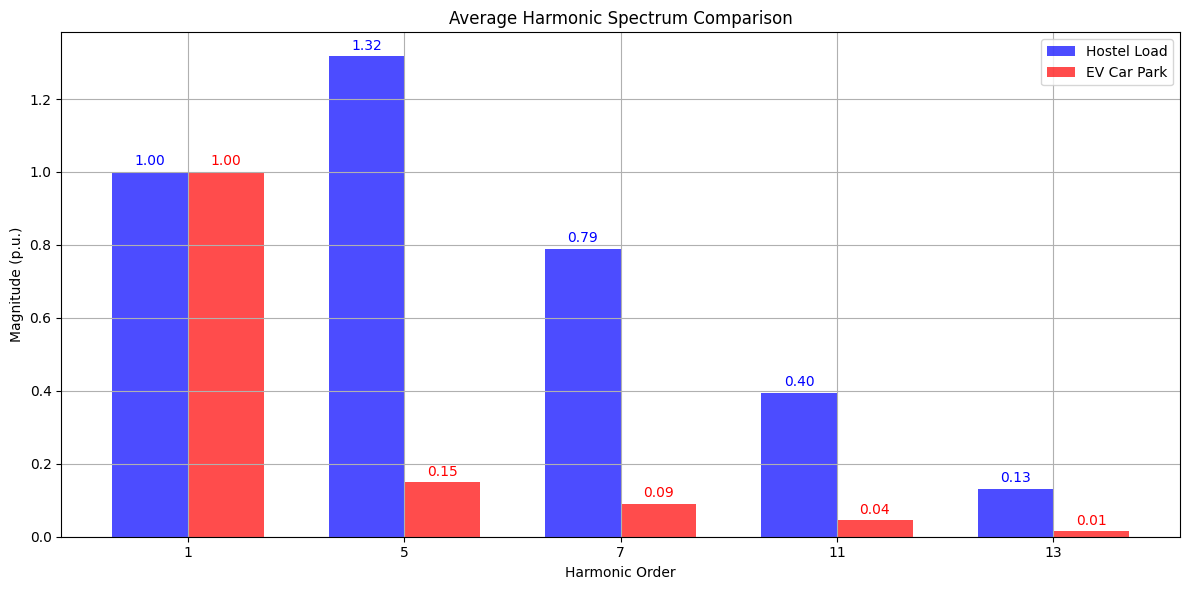

In [ ]:
# Create time axis for the plots (1 minute intervals for 1440 minutes)
time = range(1441)  # 1440 minutes for a full day

# Extract THD values for both loads
hostel_thd = average_single_hostel_thd_df['THD'].values  # Convert to NumPy array for calculations
ev_thd = average_thd_profile_ev['THD'].values          # Convert to NumPy array for calculations

print(hostel_thd)
print(ev_thd)

print(hostel_thd.shape)
print(ev_thd.shape)

# Calculate mean and standard deviation
mean_hostel_thd = np.mean(hostel_thd)
std_hostel_thd = np.std(hostel_thd)

print(mean_hostel_thd, std_hostel_thd)

mean_ev_thd = np.mean(ev_thd)
std_ev_thd = np.std(ev_thd)

# Plot THD over time with error bars
plt.figure(figsize=(14, 6))
plt.plot(time, hostel_thd, label='THD - Hostel Load', color='blue', alpha=0.6)
plt.plot(time, ev_thd, label='THD - EV Car Park', color='red', alpha=0.6)

# Adding mean and standard deviation shaded area
plt.fill_between(time, mean_hostel_thd - std_hostel_thd, mean_hostel_thd + std_hostel_thd, color='blue', alpha=0.1)
plt.fill_between(time, mean_ev_thd - std_ev_thd, mean_ev_thd + std_ev_thd, color='red', alpha=0.1)

plt.axhline(mean_hostel_thd, color='blue', linestyle='--', label='Mean THD - Hostel Load')
plt.axhline(mean_ev_thd, color='red', linestyle='--', label='Mean THD - EV Car Park')

plt.title('Total Harmonic Distortion (THD) Over Time')
plt.xlabel('Time (Minutes)')
plt.ylabel('THD')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Statistical comparison of total THD
t_stat, p_value = stats.ttest_ind(hostel_thd, ev_thd)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Function to generate harmonic spectrum based on THD
def set_harmonic_spectrum(thd):
    h5 = thd * 0.5  # 50% to 5th harmonic
    h7 = thd * 0.3  # 30% to 7th harmonic
    h11 = thd * 0.15  # 15% to 11th harmonic
    h13 = thd * 0.05  # 5% to 13th harmonic
    return [1, h5, h7, h11, h13]  # Return harmonics as a list

# Generate harmonic spectra for both loads
hostel_harmonics = [set_harmonic_spectrum(thd) for thd in hostel_thd]
ev_harmonics = [set_harmonic_spectrum(thd) for thd in ev_thd]

# Average harmonic values over the simulation period for comparison
average_hostel_harmonics = np.mean(hostel_harmonics, axis=0)
average_ev_harmonics = np.mean(ev_harmonics, axis=0)

# Harmonic orders to plot
harmonic_orders = [1, 5, 7, 11, 13]

# Plot harmonic spectra comparison
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(harmonic_orders))

bars1 = plt.bar(x - bar_width/2, average_hostel_harmonics, width=bar_width, color='blue', alpha=0.7, label='Hostel Load')
bars2 = plt.bar(x + bar_width/2, average_ev_harmonics, width=bar_width, color='red', alpha=0.7, label='EV Car Park')

# Add exact values on top of each bar
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', color='blue')

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', color='red')

plt.title('Average Harmonic Spectrum Comparison')
plt.xlabel('Harmonic Order')
plt.ylabel('Magnitude (p.u.)')
plt.xticks(x, harmonic_orders)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


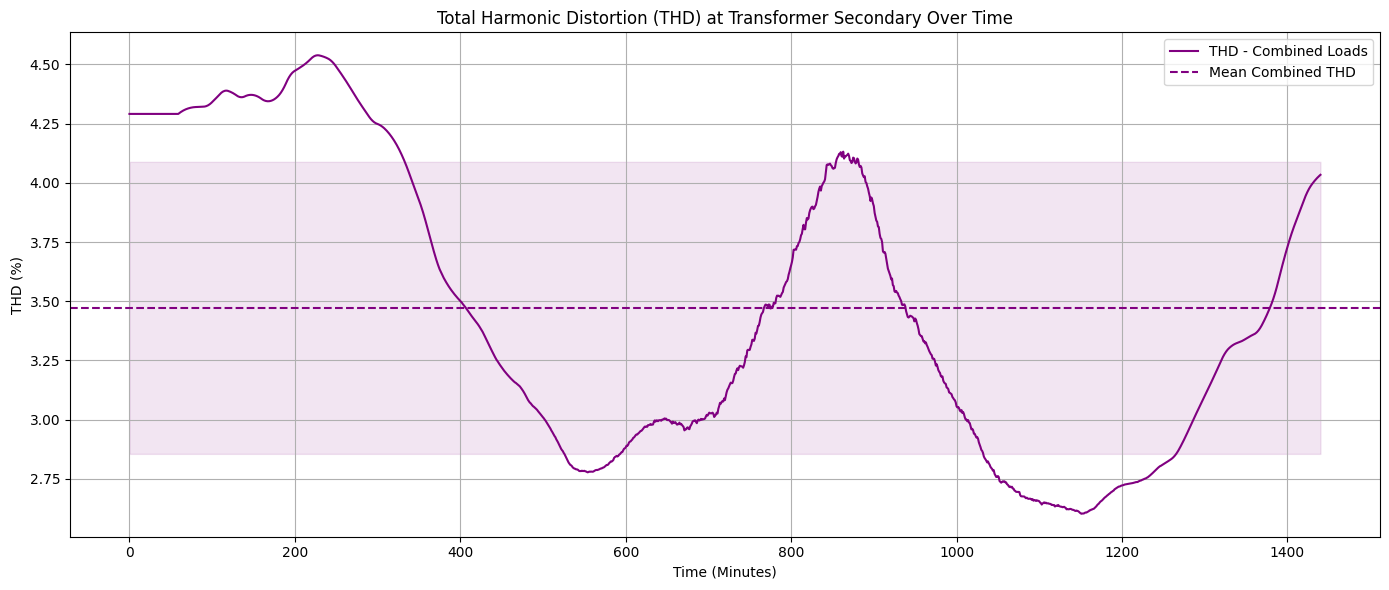

Mean Combined THD: 3.47
Standard Deviation of Combined THD: 0.62


In [ ]:
# Function to generate harmonic spectrum based on THD
def set_harmonic_spectrum(thd):
    h5 = thd * 0.5  # 50% to 5th harmonic
    h7 = thd * 0.3   # 30% to 7th harmonic
    h11 = thd * 0.15  # 15% to 11th harmonic
    h13 = thd * 0.05  # 5% to 13th harmonic
    return [1, h5, h7, h11, h13]  # Return harmonics as a list

# Generate harmonic spectra for both loads
hostel_harmonics = [set_harmonic_spectrum(thd) for thd in hostel_thd]
ev_harmonics = [set_harmonic_spectrum(thd) for thd in ev_thd]

# Combine harmonic contributions
combined_harmonics = []

for hostel, ev in zip(hostel_harmonics, ev_harmonics):
    combined = [
        hostel[0] * H + ev[0] * N,  # 1st harmonic
        (hostel[1] * H + ev[1] * N),  # 5th harmonic
        (hostel[2] * H + ev[2] * N),  # 7th harmonic
        (hostel[3] * H + ev[3] * N),  # 11th harmonic
        (hostel[4] * H + ev[4] * N)   # 13th harmonic
    ]
    combined_harmonics.append(combined)

# Convert to NumPy array for easier calculations
combined_harmonics = np.array(combined_harmonics)

# Calculate combined THD for each time step
combined_thd = np.sqrt((combined_harmonics[:, 1]/.5)**2  + (combined_harmonics[:, 2]/.3)**2 +
                        (combined_harmonics[:, 3]/.15)**2 + (combined_harmonics[:, 4]/.05)**2)/(hostel[0] * H + ev[0] * N)

# Calculate average combined THD
mean_combined_thd = np.mean(combined_thd)
std_combined_thd = np.std(combined_thd)

# Plot Combined THD over time
plt.figure(figsize=(14, 6))
plt.plot(range(1441), combined_thd, label='THD - Combined Loads', color='purple')
plt.axhline(mean_combined_thd, color='purple', linestyle='--', label='Mean Combined THD')

# Adding mean and standard deviation shaded area
plt.fill_between(range(1441), mean_combined_thd - std_combined_thd, mean_combined_thd + std_combined_thd,
                 color='purple', alpha=0.1)

plt.title('Total Harmonic Distortion (THD) at Transformer Secondary Over Time')
plt.xlabel('Time (Minutes)')
plt.ylabel('THD (%)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Output mean and std for combined THD
print(f"Mean Combined THD: {mean_combined_thd:.2f}")
print(f"Standard Deviation of Combined THD: {std_combined_thd:.2f}")


# Objectives

## Transfomer Lifespan Analysis

In [ ]:
print(average_load_profile_all_ev_df['PT'].isna().sum())  # This should print 0 if all NaNs are filled
print(average_load_profile_all_h_df['PT'].isna().sum())  # This should print 0 if all NaNs are filled


0
59


In [ ]:
average_load_profile_all_h_df['PT'] = average_load_profile_all_h_df['PT'].ffill().bfill()
average_load_profile_all_h_df['ST'] = average_load_profile_all_h_df['ST'].ffill().bfill()



In [ ]:
print(average_load_profile_all_ev_df['PT'].isna().sum())  # This should print 0 if all NaNs are filled
print(average_load_profile_all_h_df['PT'].isna().sum())  # This should print 0 if all NaNs are filled


0
0


In [ ]:
# Assuming average_load_profile_all_h_df has the extra row
combined_load_pt = average_load_profile_all_ev_df['PT'].values + average_load_profile_all_h_df['PT'].values[:-1]  # Exclude the last row of average_load_profile_all_h_df
combined_load_st = average_load_profile_all_ev_df['ST'].values + average_load_profile_all_h_df['ST'].values[:-1]  # Exclude the last row of average_load_profile_all_h_df
time_in_minutes = average_load_profile_all_ev_df['minutes'].values

# Create a new DataFrame for the combined load
combined_load_profile_df = pd.DataFrame({'minutes': time_in_minutes, 'PT': combined_load_pt, 'ST': combined_load_st})

print(combined_load_profile_df.tail())

      minutes          PT          ST
1435     1435  249.828352  308.433960
1436     1436  248.901241  307.513156
1437     1437  248.008334  306.627708
1438     1438  247.149631  305.777614
1439     1439  246.325132  304.962875


In [ ]:
# Transformer and thermal constants (you may need to adjust these based on actual transformer data)
transformer_size = 500  # Transformer rated size (kVA)
x = 0.8
exponent_y = 1.6
R = 8
k11 = 1
k21 = 1
k22 = 2
tau_w = 4  # Winding time constant (hours)
tau_o = 180  # Oil time constant (hours)
delta_theta_or = 45  # Top-oil rise at rated losses (°C)
delta_theta_hr = 45  # Hot-spot-to-oil gradient at rated current (°C)
theta_alpha = 30  # Ambient temperature (constant, °C)
transformer_lifetime_hours = 65000  #Assuming a transformer's lifetime at 50% retained tensile strength is 65000 hours.

# Assuming 'total_load_df' is already defined and contains the 'Total_PT' column
# Calculating the load factor K
K = combined_load_profile_df['PT'] / transformer_size

K_no_EV = average_load_profile_all_h_df['PT'].values[:-1] / transformer_size

# Prepare DataFrame for K values
K_df = pd.DataFrame({
    'minutes': range(1440),
    'K': K  # The load factor K over 24 hours
})

K_df_no_EV = pd.DataFrame({
    'minutes': range(1440),
    'K': K_no_EV  # The load factor K over 24 hours
})

In [ ]:
# Resample the data to hourly by grouping every 60 minutes and taking the mean
K_hourly_df = K_df.groupby(K_df.index // 60).mean()
K_hourly_df['hours'] = range(24)

K_hourly_df_no_EV = K_df_no_EV.groupby(K_df_no_EV.index // 60).mean()
K_hourly_df_no_EV['hours'] = range(24)

# Drop the 'minutes' column as it is no longer relevant after conversion to hours
K_hourly_df = K_hourly_df.drop(columns=['minutes'])
K_hourly_df_no_EV = K_hourly_df_no_EV.drop(columns=['minutes'])

# Reset the index to get a cleaner DataFrame
K_hourly_df = K_hourly_df.reset_index(drop=True)
K_hourly_df_no_EV = K_hourly_df_no_EV.reset_index(drop=True)

In [ ]:
# Initial conditions
theta_o_init = 25  # Initial top-oil temperature (°C)
Delta_theta_h1_init = 20  # Initial hot-spot temperature rise (part 1)
Delta_theta_h2_init = 10  # Initial hot-spot temperature rise (part 2)

# Time range for 24 hours in minutes
t_span = [0, 24]
t_eval = np.linspace(0, 24, 1000)

In [ ]:
def thermal_model(t, y, K_df):
    theta_o, Delta_theta_h1, Delta_theta_h2 = y

    # Interpolating K for the current time t (ensure this is a scalar)
    K_t = float(np.interp(t, K_hourly_df['hours'], K_df['K']))

    # Top-oil temperature differential equation (ensure scalars are returned)
    dtheta_o_dt = ((1 + K_t**2 * R )/ (1 + R))**x * delta_theta_or / (k11 * tau_o) - (theta_o - theta_alpha) / tau_o

    # Hot-spot temperature rise equations (ensure scalars are returned)
    dDelta_theta_h1_dt = (k21 * K_t**exponent_y * delta_theta_hr - Delta_theta_h1) / (k22 * tau_w)
    dDelta_theta_h2_dt = ((k21 - 1) * K_t**exponent_y * delta_theta_hr - Delta_theta_h2) / (tau_o * k22)

    # Return the rates of change as a list of scalars
    return [dtheta_o_dt, dDelta_theta_h1_dt, dDelta_theta_h2_dt]

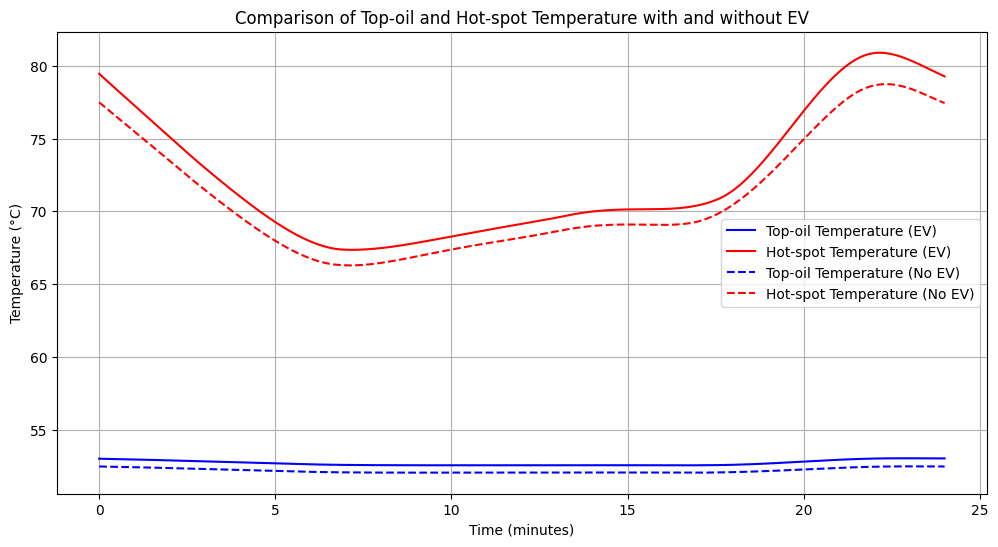

In [29]:
num_days = 3650  # Number of iterations (days)
# Loop for EV case
for day in range(num_days):
    # Solve the ODEs for this day
    sol = solve_ivp(
        thermal_model, t_span, [theta_o_init, Delta_theta_h1_init, Delta_theta_h2_init],
        t_eval=t_eval, args=(K_hourly_df,)
    )

    # Extract the final conditions at the end of the day (last time step)
    theta_o_final = sol.y[0, -1]
    Delta_theta_h1_final = sol.y[1, -1]
    Delta_theta_h2_final = sol.y[2, -1]

    # Update the initial conditions for the next day with the final conditions of this day
    theta_o_init = theta_o_final
    Delta_theta_h1_init = Delta_theta_h1_final
    Delta_theta_h2_init = Delta_theta_h2_final

# After the iterations are done, you can use the final initial condition
# to solve the ODE one last time for the converged state
sol_final = solve_ivp(
    thermal_model, t_span, [theta_o_init, Delta_theta_h1_init, Delta_theta_h2_init],
    t_eval=t_eval, args=(K_hourly_df,)
)

theta_o_init_no_EV, Delta_theta_h1_init_no_EV, Delta_theta_h2_init_no_EV = theta_o_init, Delta_theta_h1_init, Delta_theta_h2_init

for day in range(num_days):
    # Solve the ODEs for this day without EV
    sol_no_EV = solve_ivp(
        thermal_model, t_span, [theta_o_init_no_EV, Delta_theta_h1_init_no_EV, Delta_theta_h2_init_no_EV],
        t_eval=t_eval, args=(K_hourly_df_no_EV,)
    )

    # Extract the final conditions at the end of the day (last time step)
    theta_o_final_no_EV = sol_no_EV.y[0, -1]
    Delta_theta_h1_final_no_EV = sol_no_EV.y[1, -1]
    Delta_theta_h2_final_no_EV = sol_no_EV.y[2, -1]

    # Update the initial conditions for the next day
    theta_o_init_no_EV = theta_o_final_no_EV
    Delta_theta_h1_init_no_EV = Delta_theta_h1_final_no_EV
    Delta_theta_h2_init_no_EV = Delta_theta_h2_final_no_EV

# Final solution for No EV
sol_final_no_EV = solve_ivp(
    thermal_model, t_span, [theta_o_init_no_EV, Delta_theta_h1_init_no_EV, Delta_theta_h2_init_no_EV],
    t_eval=t_eval, args=(K_hourly_df_no_EV,)
)

# Extract the solutions
theta_o_sol = sol_final.y[0]  # Top-oil temperature with EV
Delta_theta_h1_sol = sol_final.y[1]  # Hot-spot temperature rise part 1 with EV
Delta_theta_h2_sol = sol_final.y[2]  # Hot-spot temperature rise part 2 with EV

theta_o_sol_no_EV = sol_final_no_EV.y[0]  # Top-oil temperature without EV
Delta_theta_h1_sol_no_EV = sol_final_no_EV.y[1]  # Hot-spot temperature rise part 1 without EV
Delta_theta_h2_sol_no_EV = sol_final_no_EV.y[2]  # Hot-spot temperature rise part 2 without EV

# Calculate total hot-spot temperature rise and hot-spot temperature
Delta_theta_h_sol = Delta_theta_h1_sol - Delta_theta_h2_sol
theta_h_sol = theta_o_sol + Delta_theta_h_sol

Delta_theta_h_sol_no_EV = Delta_theta_h1_sol_no_EV - Delta_theta_h2_sol_no_EV
theta_h_sol_no_EV = theta_o_sol_no_EV + Delta_theta_h_sol_no_EV

# Plot the results
plt.figure(figsize=(12, 6))

# Plot with EV (solid lines)
plt.plot(t_eval, theta_o_sol, label="Top-oil Temperature (EV)", color="blue", linestyle='-')
plt.plot(t_eval, theta_h_sol, label="Hot-spot Temperature (EV)", color="red", linestyle='-')

# Plot without EV (dotted lines)
plt.plot(t_eval, theta_o_sol_no_EV, label="Top-oil Temperature (No EV)", color="blue", linestyle='--')
plt.plot(t_eval, theta_h_sol_no_EV, label="Hot-spot Temperature (No EV)", color="red", linestyle='--')

plt.xlabel('Time (minutes)')
plt.ylabel('Temperature (°C)')
plt.title('Comparison of Top-oil and Hot-spot Temperature with and without EV')
plt.legend()
plt.grid(True)
plt.show()


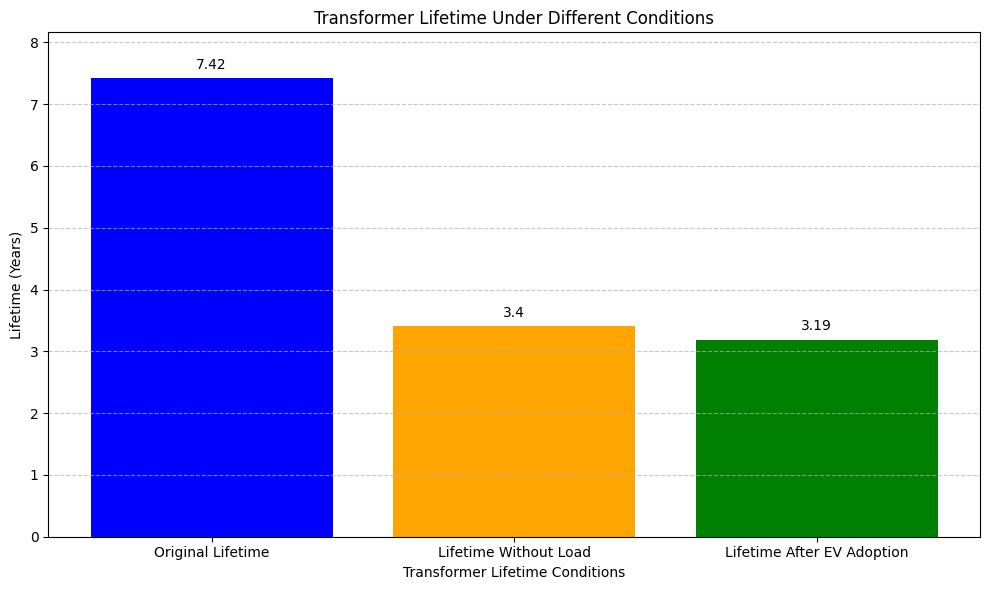

Original Transformer Lifetime (without load): 7.42 years
Transformer Lifetime (after load without EVs): 3.40 years
Transformer Lifetime (after EV adoption): 3.19 years
The original transformer lifetime without any load is approximately 7.42 years.
After accounting for the load without electric vehicles, the transformer lifetime decreases to 3.40 years due to the additional stress from the load.
With the adoption of electric vehicles, the lifetime further decreases to approximately 3.19 years, highlighting the significant impact of EVs on transformer lifespan.


In [ ]:
# Calculate Vt and Vt_no_EV
Vt = 2 ** ((theta_h_sol - 98) / 6)
Vt_no_EV = 2 ** ((theta_h_sol_no_EV - 98) / 6)

# Calculate the loss of life Lt over the 24-hour period using trapezoidal integration
Lt = np.trapz(Vt, t_eval)
Lt_no_EV = np.trapz(Vt_no_EV, t_eval)

# Calculate transformer lifetimes
transformer_orgianl_life = (transformer_lifetime_hours / 24) / 365
transformer_lifetime_afterEVC_years = ((transformer_lifetime_hours / (1 + Lt)) / 24) / 365
transformer_lifetime_years = ((transformer_lifetime_hours / (1 + Lt_no_EV)) / 24) / 365

# Prepare data for bar chart
labels = ['Original Lifetime', 'Lifetime Without Load', 'Lifetime After EV Adoption']
values = [transformer_orgianl_life, transformer_lifetime_years, transformer_lifetime_afterEVC_years]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['blue', 'orange', 'green'])
plt.xlabel('Transformer Lifetime Conditions')
plt.ylabel('Lifetime (Years)')
plt.title('Transformer Lifetime Under Different Conditions')
plt.ylim(0, max(values) * 1.1)  # Set y-limit to a bit higher than the max value for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Adding numerical values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

# Show the plot
plt.show()

# Explanation of the results
print(f"Original Transformer Lifetime (without load): {transformer_orgianl_life:.2f} years")
print(f"Transformer Lifetime (after load without EVs): {transformer_lifetime_years:.2f} years")
print(f"Transformer Lifetime (after EV adoption): {transformer_lifetime_afterEVC_years:.2f} years")

explanation = (
    f"The original transformer lifetime without any load is approximately {transformer_orgianl_life:.2f} years.\n"
    f"After accounting for the load without electric vehicles, the transformer lifetime decreases to "
    f"{transformer_lifetime_years:.2f} years due to the additional stress from the load.\n"
    f"With the adoption of electric vehicles, the lifetime further decreases to approximately "
    f"{transformer_lifetime_afterEVC_years:.2f} years, highlighting the significant impact of EVs on transformer lifespan."
)

print(explanation)


## Power Factor Analysis


In [30]:
combined_pf = combined_load_profile_df['PT']/combined_load_profile_df['ST']
no_evc_pf = average_load_profile_all_h_df['PT']/average_load_profile_all_h_df['ST']

pf_minute_df = pd.DataFrame({'minutes': range(1441),'combined_pf': combined_pf, 'no_evc_pf': no_evc_pf, 'combined_ST': combined_load_profile_df['ST'],  # Add ST for combined scenario
    'no_evc_ST': average_load_profile_all_h_df['ST']  # Add ST for no EVC scenario
                             })

#filling the now values
pf_minute_df = pf_minute_df.ffill().bfill()




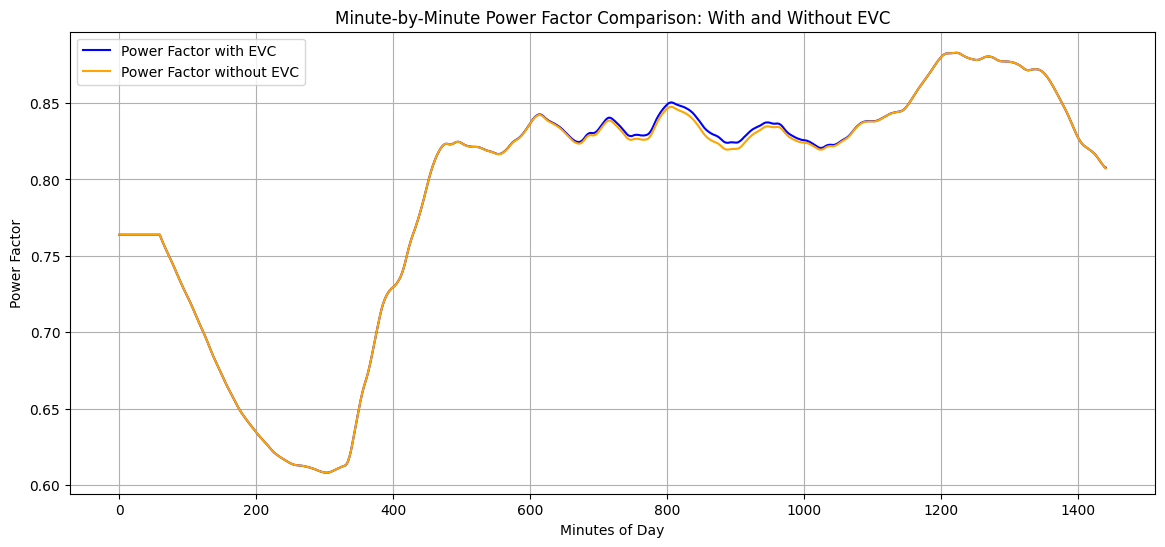

In [31]:


# Plot power factor comparison with and without EVC
plt.figure(figsize=(14, 6))
plt.plot(pf_minute_df['minutes'], pf_minute_df['combined_pf'], label='Power Factor with EVC', color='blue',)
plt.plot(pf_minute_df['minutes'], pf_minute_df['no_evc_pf'], label='Power Factor without EVC', color='orange',)
plt.xlabel('Minutes of Day')
plt.ylabel('Power Factor')
plt.title('Minute-by-Minute Power Factor Comparison: With and Without EVC')
plt.legend()
plt.grid(True)
plt.show()



## Voltage Deviation

In [32]:
pip install pandapower

## Power System Losses

In [33]:
import os
import numpy as np
import pandas as pd
import tempfile
import random
import pandapower as pp
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl

In [34]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    return ow

In [35]:
def create_controllers(net, ds):
    print("In the create controller")

    try:
        # print("Hostel profile:", ds.df["hostel_p"])
        ConstControl(net, element='load', variable='p_mw', element_index=[0],
                     data_source=ds, profile_name=["hostel_p"])
        print("Hostel Controller created successfully")
    except Exception as e:
        print("Error creating Hostel Controller:", e)

    try:
        # print("EV profile:", ds.df["ev_p"])
        ConstControl(net, element='load', variable='p_mw', element_index=[0],
                     data_source=ds, profile_name=["ev_p"])
        print("EV Controller created successfully")
    except Exception as e:
        print("Error creating EV Controller:", e)


In [36]:
def create_data_source():
    profiles = pd.DataFrame()

    profiles['ev_p'] = average_load_profile_ev_df['PT']/1000

    profiles['hostel_p'] = average_load_profile_all_h_df['PT']/100
    0
    print(profiles.head())

    ds = DFData(profiles)
    return profiles, ds

In [37]:
def timeseries_example(output_dir):
    # 1. create test net
    net = simple_test_net()

    # 2. create (random) data source
    n_timesteps = 1440
    profiles, ds = create_data_source()
    # 3. create controllers (to control P values of the load and the sgen)
    create_controllers(net, ds)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps)


In [41]:
def simple_test_net():
    """
    simple net that looks like:

    ext_grid b0---b1 trafo(11/.4)b2-------- b3---- hostel
                                            |
                                            |
                                            ev
    """
    net = pp.create_empty_network()
    pp.set_user_pf_options(net, init_vm_pu = "flat", init_va_degree = "auto", calculate_voltage_angles=True)

    b0 = pp.create_bus(net, 11)
    b1 = pp.create_bus(net, .4)
    b2 = pp.create_bus(net, .4)

    # pp.create_ext_grid(net, b0, pu=1.0)
    pp.create_gen(net, bus=b0, p_mw=25, vm_pu=1.0, slack=True, name="Slack Generator")
    # pp.create_line(net, b0, b1, .6, "NAYY 4x50 SE")
    trafo_data = {
        "sn_mva": .5,          # Rated power in MVA
        "vn_hv_kv": 11,       # High voltage side (primary)
        "vn_lv_kv": .4,        # Low voltage side (secondary)
        "vk_percent": 6.0,      # Short-circuit voltage (in %)
        "vkr_percent": 0.78,    # Short-circuit losses (in %)
        "pfe_kw": 1.1,          # Iron losses in kW
        "i0_percent": 0.28,     # No-load current (in %)
        "shift_degree": 0,      # Phase-shift (in degrees)
    }

    # Create custom transformer type and add transformer
    pp.create_std_type(net, trafo_data, name="500kVA 11/0.4 kV", element='trafo')
    pp.create_transformer(net, hv_bus=b0, lv_bus=b1, std_type="500kVA 11/0.4 kV", name="500kVA Transformer")

    line_data = {
        "r_ohm_per_km": 0.1,
        "x_ohm_per_km": 0.1,
        "max_i_ka": 1.24,
        "c_nf_per_km": 0,

    }
    pp.create_std_type(net, line_data, name="UNZA line 11/0.4kV", element='line')

    pp.create_line(net, b1,b2,.1,"UNZA line 11/0.4kV")

    ev_p_kw_avg = np.mean(average_load_profile_ev_df['PT'])/1000
    hostel_p_kw_avg = np.mean(average_load_profile_all_h_df['PT'])/1000

    ev_s_kvar_avg = np.mean(average_load_profile_ev_df['ST'])/1000
    hostel_s_kvar_avg = np.mean(average_load_profile_all_h_df['ST'])/1000

    pp.create_load(net, b2, p_mw=ev_p_kw_avg, p_mvar=ev_s_kvar_avg, name='ev_p')
    pp.create_load(net, b2, p_mw=hostel_p_kw_avg, p_mvar = hostel_s_kvar_avg, name='hostel_p')

    pp.runpp(net)
    return net

In [42]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

timeseries_example(output_dir)

Results can be found in your local temp folder: /tmp/time_series_example


UserWarning: c_nf_per_km is required as line type parameter

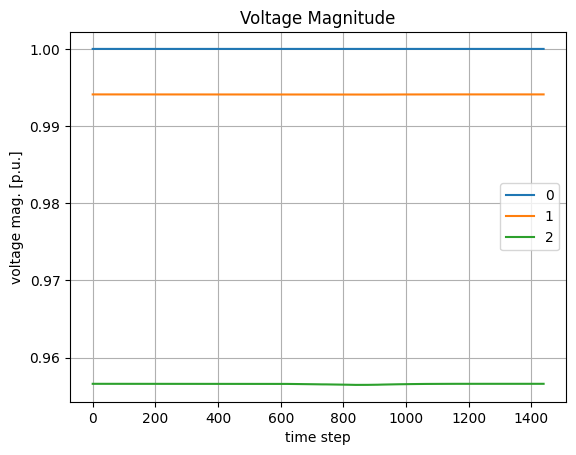

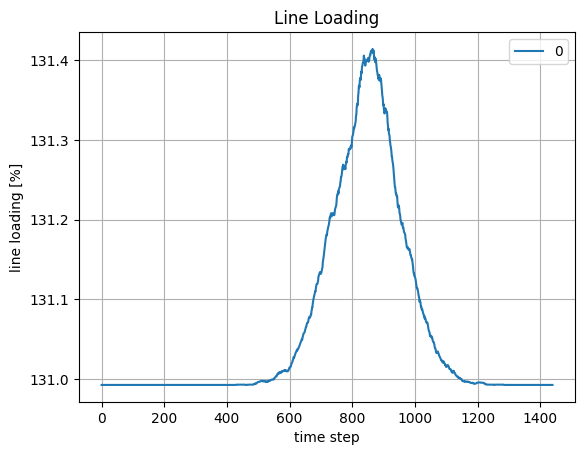

In [40]:
# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()